## Домашнее задание: "Детекция объектов на изображении"

## Ильин Илья Юрьевич

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели. 

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество). 
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random

import cv2

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.patches as patches

### Напишем класс который будет возвращать саму картинку и боксы с лейблами 

In [62]:
class BallDetectionDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file, 'r') as file:
            data = json.load(file)
            self.img_paths = list(data.keys())
            self.img_annots = list(data.values())

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])       
        annot = self.img_annots[idx]
        
        image = Image.open(img_path, mode='r')
        image = image.convert('RGB')
        
        #w_old, h_old = image.width, image.height

        if self.transform:
            image = self.transform(image)
        
        w, h = image.shape[1:]
        
        boxes = []
        for bbox in self.img_annots[idx]:
            xmin = bbox[0] * w#/w_old
            xmax = bbox[1] * w#/w_old
            ymin = bbox[2] * h#/h_old
            ymax = bbox[3] * h#/h_old
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = np.asarray(boxes)  # N x 4
        
        target = {}
        target['boxes'] = torch.Tensor(boxes)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)
        
        return image, target

## Переведем данные датасета в тензор

In [63]:
def collater(data):
    imgs = []
    targets = []
    
    for image, target in data:
        imgs.append(image)
        targets.append(target)
        
    imgs = torch.stack(imgs, dim=0)
    
    return imgs, targets

### Посмотрим сохраняются ли ground truth box после различных transform

In [64]:
train_transform = transforms.Compose([
    #transforms.transforms.GaussianBlur(kernel_size=3),
    torchvision.transforms.RandomAffine(degrees = 11, translate=(0.2,0.2)),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

training_data = BallDetectionDataset(annotations_file='/home/ubuntu/Downloads/data_CNN/seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json',
        img_dir='/home/ubuntu/Downloads/data_CNN/seminar_objdet_retina_oi5_ball',
        transform=train_transform,
    )
img , t = training_data.__getitem__(0)

In [65]:
x1, y1, x2, y2 = t['boxes'][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


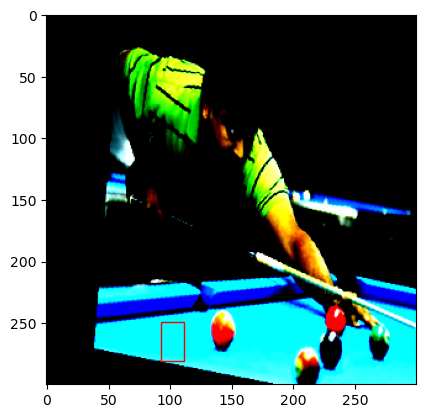

In [66]:
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
plt.imshow(img.permute(1, 2, 0))
plt.gca().add_patch(rect)

### Итог: после поворотов, сдвигов box не соответсвует таргету. При resize все сохраняется. То есть для некоторых трансформаций надо также и перемещать боксы

### Train loop

In [80]:
def train(model, optimizer, epochs):
  
    train_transform = transforms.Compose([
    #torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),    
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

    training_data = BallDetectionDataset(annotations_file='/home/ubuntu/Downloads/data_CNN/seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json',
        img_dir='/home/ubuntu/Downloads/data_CNN/seminar_objdet_retina_oi5_ball',
        transform=train_transform,
    )
    
    train_dataloader = DataLoader(training_data, batch_size=16, collate_fn=collater)
    
    metric = MeanAveragePrecision(box_format='xyxy')
    for j in range(epochs):
        print_freq = int(16)
        model.train()
        res = []
        for i, (imgs, targets) in enumerate(train_dataloader):
            model.train() 
            imgs = imgs.to(device)
            targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

            loss_dict = model(imgs, targets)
            loss = sum(list(loss_dict.values()))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            if i and i % 16 == 0:
                model.eval()
                mAP = metric(model(imgs), targets)['map'].item()
                print(f'Epoch: [{j}]:\tLoss = {loss:.4f},\tmAP = {mAP:.4f}')
                res.append(mAP)
                del mAP

            del imgs, targets, loss_dict, loss
    return res

## Обучим на легковесной модели из torch models с предобученными весами без замораживания весов

In [81]:
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes =91, trainable_backbone_layers = 6)
model.head.classifier = torch.nn.Linear(256, 2)  
model.head.score = torch.nn.Linear(256, 4)  # тут скорее всего 4

 


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # используется только cpu
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.004)

In [83]:
%%time
res = train(model, optimizer, 4)

Epoch: [0]:	Loss = 6.8347,	mAP = 0.0015
Epoch: [0]:	Loss = 5.3359,	mAP = 0.0053
Epoch: [0]:	Loss = 4.9350,	mAP = 0.0239
Epoch: [0]:	Loss = 4.7539,	mAP = 0.0003
Epoch: [0]:	Loss = 5.1832,	mAP = 0.0001
Epoch: [0]:	Loss = 4.9143,	mAP = 0.0196
Epoch: [0]:	Loss = 4.2989,	mAP = 0.0092
Epoch: [0]:	Loss = 4.4610,	mAP = 0.0280
Epoch: [0]:	Loss = 5.0691,	mAP = 0.0367
Epoch: [0]:	Loss = 4.9810,	mAP = 0.0375
Epoch: [0]:	Loss = 3.5656,	mAP = 0.1601
Epoch: [1]:	Loss = 4.2528,	mAP = 0.1444
Epoch: [1]:	Loss = 3.8067,	mAP = 0.1774
Epoch: [1]:	Loss = 4.2159,	mAP = 0.1500
Epoch: [1]:	Loss = 3.5790,	mAP = 0.1468
Epoch: [1]:	Loss = 4.0860,	mAP = 0.0720
Epoch: [1]:	Loss = 3.8700,	mAP = 0.1275
Epoch: [1]:	Loss = 3.1826,	mAP = 0.1808
Epoch: [1]:	Loss = 3.9253,	mAP = 0.0705
Epoch: [1]:	Loss = 4.3083,	mAP = 0.0854
Epoch: [1]:	Loss = 3.9842,	mAP = 0.0521
Epoch: [1]:	Loss = 2.6729,	mAP = 0.2167
Epoch: [2]:	Loss = 3.9191,	mAP = 0.1919
Epoch: [2]:	Loss = 2.7987,	mAP = 0.1763
Epoch: [2]:	Loss = 3.1611,	mAP = 0.1449


### График предобученной модели без жестких аугментаций по батчам ( 4 эпохи )

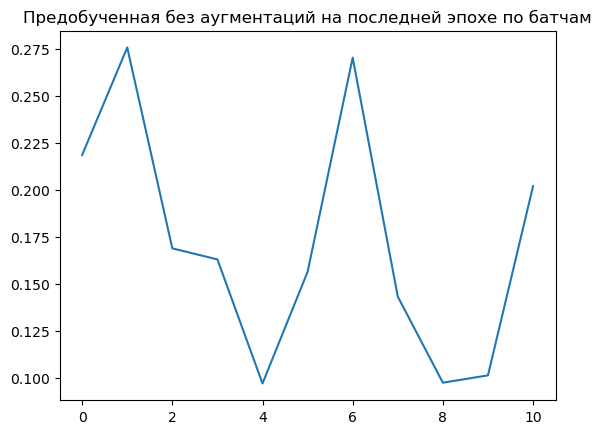

In [77]:
plt.plot(res)
plt.title("Предобученная, без аугментаций -  на последней эпохе по батчам")
plt.show()

### График не предобученной модели без жестких аугментаций по батчам ( 4 эпохи )

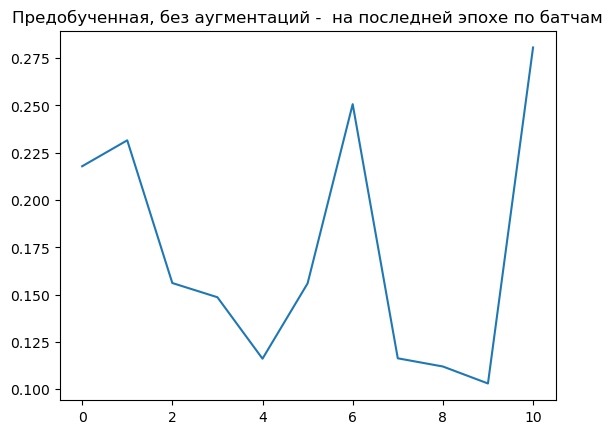

In [84]:
plt.plot(res)
plt.show()

### График предобученной модели c жесткими аугментациями по батчам ( 4 эпохи )

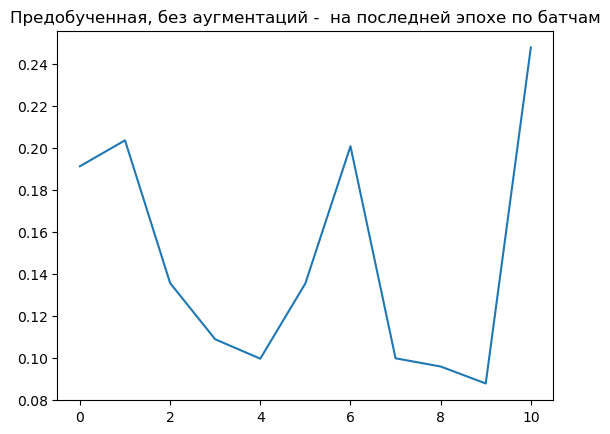

In [92]:
plt.plot(res)
plt.show()

## Выводы: результаты представлены на последней 4 эпохе. Как и ожидалось предобученная получше справилась с задачей. С жесткими аугментациями тяжелее обучаться.  За время обучения максимум метрики показал около 0.3. Что говорит о том что модель обучилась, но не достаточно хорошо. Проблемы преположительно такие:
* недостаточное кол-во данных
* легкая модель
* малое кол-во эпох
